# 캐글 자전거 대여 경진대회 https://www.kaggle.com/c/bike-sharing-demand/data

<h2> Dataset Description </h2>

- 2년 동안 자전거를 대여한 데이터가 제공된다. 훈련데이터는 매월 첫 19일까지이고 테스트데이터는 20일부터 말일까지이다.
- 훈련 데이터를 통하여 테스트 데이터의 count를 예측하라

<h2> DataField </h2>

* datetime - hourly date + timestamp
* season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

<h2> Evaluation </h2>

+ Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE).
+ 분류와 회귀(예측)문제 중 회귀와 관련 된 문제라서 RMSE사용

In [1]:
# 필요한 패키지를 불러온다
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 노트북에 그래프를 그릴거기 때문
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프 폰트 사이즈 변경, 마이너스 폰트 깨지는 문제 해결
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.unicode_minus'] = False

Duplicate key in file WindowsPath('c:/Users/Master/anaconda3/envs/oks/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  sans-serif')
Duplicate key in file WindowsPath('c:/Users/Master/anaconda3/envs/oks/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 256 ('font.size: 20.0')


In [2]:
# train.csv를 train으로 불러오고 datetime칼럼을 날짜형식으로 지정함
train = pd.read_csv('./data/train.csv', parse_dates=['datetime'])
# train에 대한 정보를 보여줌
print(train.info())
train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [3]:
# 온도의 정보 확인 가능
train['temp'].describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [4]:
# train 데이터의 결측치가 몇개인지 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<AxesSubplot:>

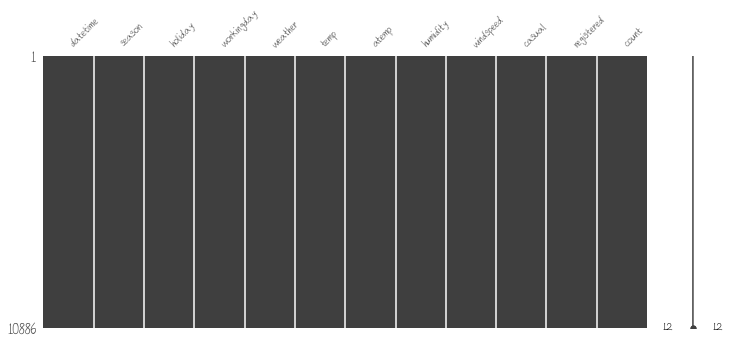

In [5]:
# 결측치를 쉽게 확인하기 위해 시각화 한 것
import missingno as msno
msno.matrix(train, figsize=(12, 5))

In [6]:
# datetime의 년, 월, 일, 시, 분, 초를 쉽게 보기 위하여 각각의 칼럼으로 지정해줌
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

In [7]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

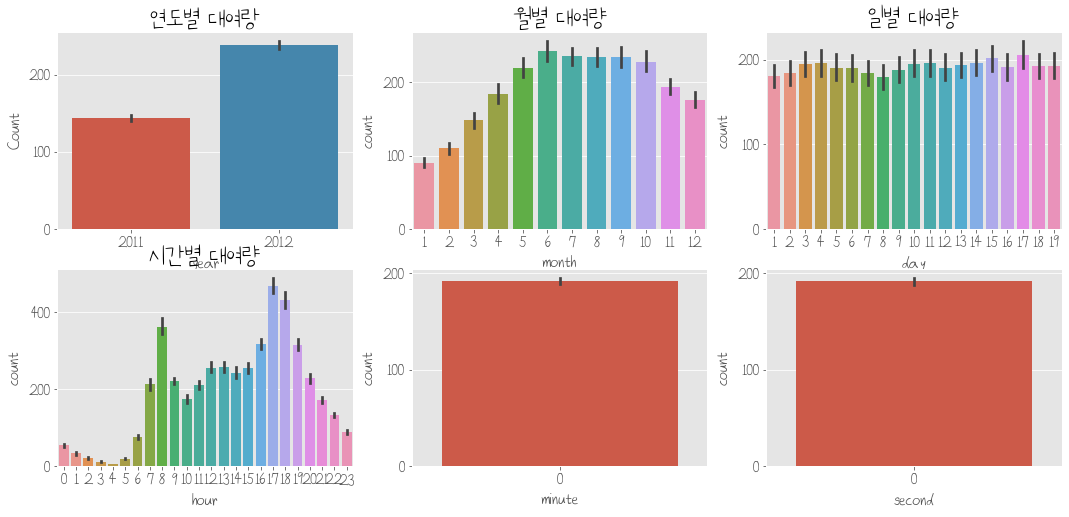

In [8]:
# 년, 월, 일, 시, 분, 초별 count를 시각화
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 8)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='minute', y='count', ax=ax5)
sns.barplot(data=train, x='second', y='count', ax=ax6)

ax1.set(ylabel='Count', title='연도별 대여랑')
ax2.set(xlabel='month', title="월별 대여량")
ax3.set(xlabel='day', title='일별 대여량')
ax4.set(xlabel='hour', title="시간별 대여량")

* 연도별 대여량에서 2011년 보다 2012년이 대여량이 더 많다
* 월별 대여량에서 6월에 대여량이 가장 많고 1월이 가장 적다(겨울에는 대체적으로 대여량이 적다)
* 일별 대여량에서는 19일까지만 표시되는 것은 train데이터라 그렇다. 일별 대여량은 다 고만고만하다
* 시간별 대여량을 보면 18~19시가 대여량이 가장 많은 시간대이고 8시도 많다(출, 퇴근을 하는 시간이라 그런거 같다) 하지만 주말인지 평일인지는 모른다
* 분, 초는 전부 0이기 때문에 의미가 없다


[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

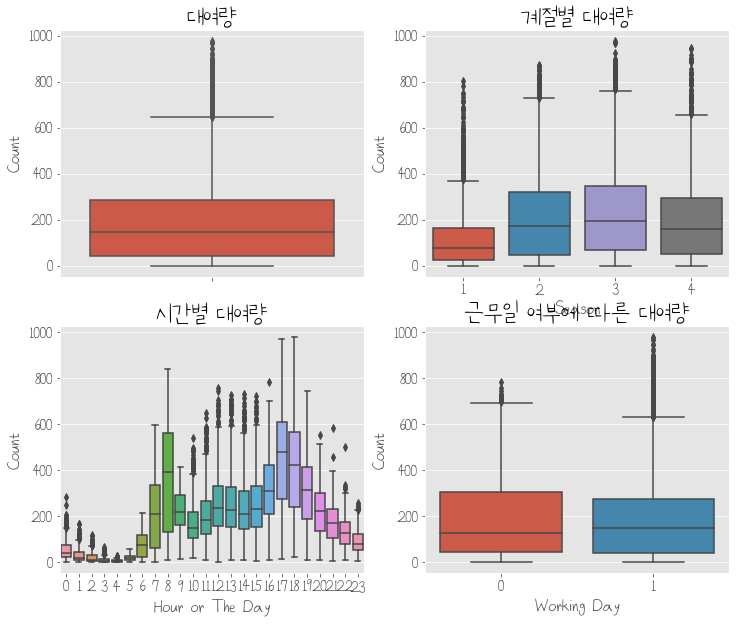

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train, y='count', orient='v', ax=ax1)
sns.boxplot(data=train, y='count', x='season', ax=ax2)
sns.boxplot(data=train, y='count', x='hour', orient='v', ax=ax3)
sns.boxplot(data=train, y='count', x='workingday', orient='v', ax=ax4)

ax1.set(ylabel='Count', title='대여량')
ax2.set(xlabel='Season', ylabel='Count', title="계절별 대여량")
ax3.set(xlabel='Hour or The Day', ylabel='Count', title='시간별 대여량')
ax4.set(xlabel='Working Day', ylabel='Count', title='근무일 여부에 따른 대여량')


In [13]:
# dayofweek라는 칼럼을 만들고 월요일~일요일까지 0~6으로 표시(0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일)
train['dayofweek'] = train['datetime'].dt.dayofweek

In [14]:
train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

In [15]:
train.shape

(10886, 19)

In [16]:
train.rename(columns={'datofweek':'dayofweek'}, inplace=True)

<AxesSubplot:xlabel='hour', ylabel='count'>

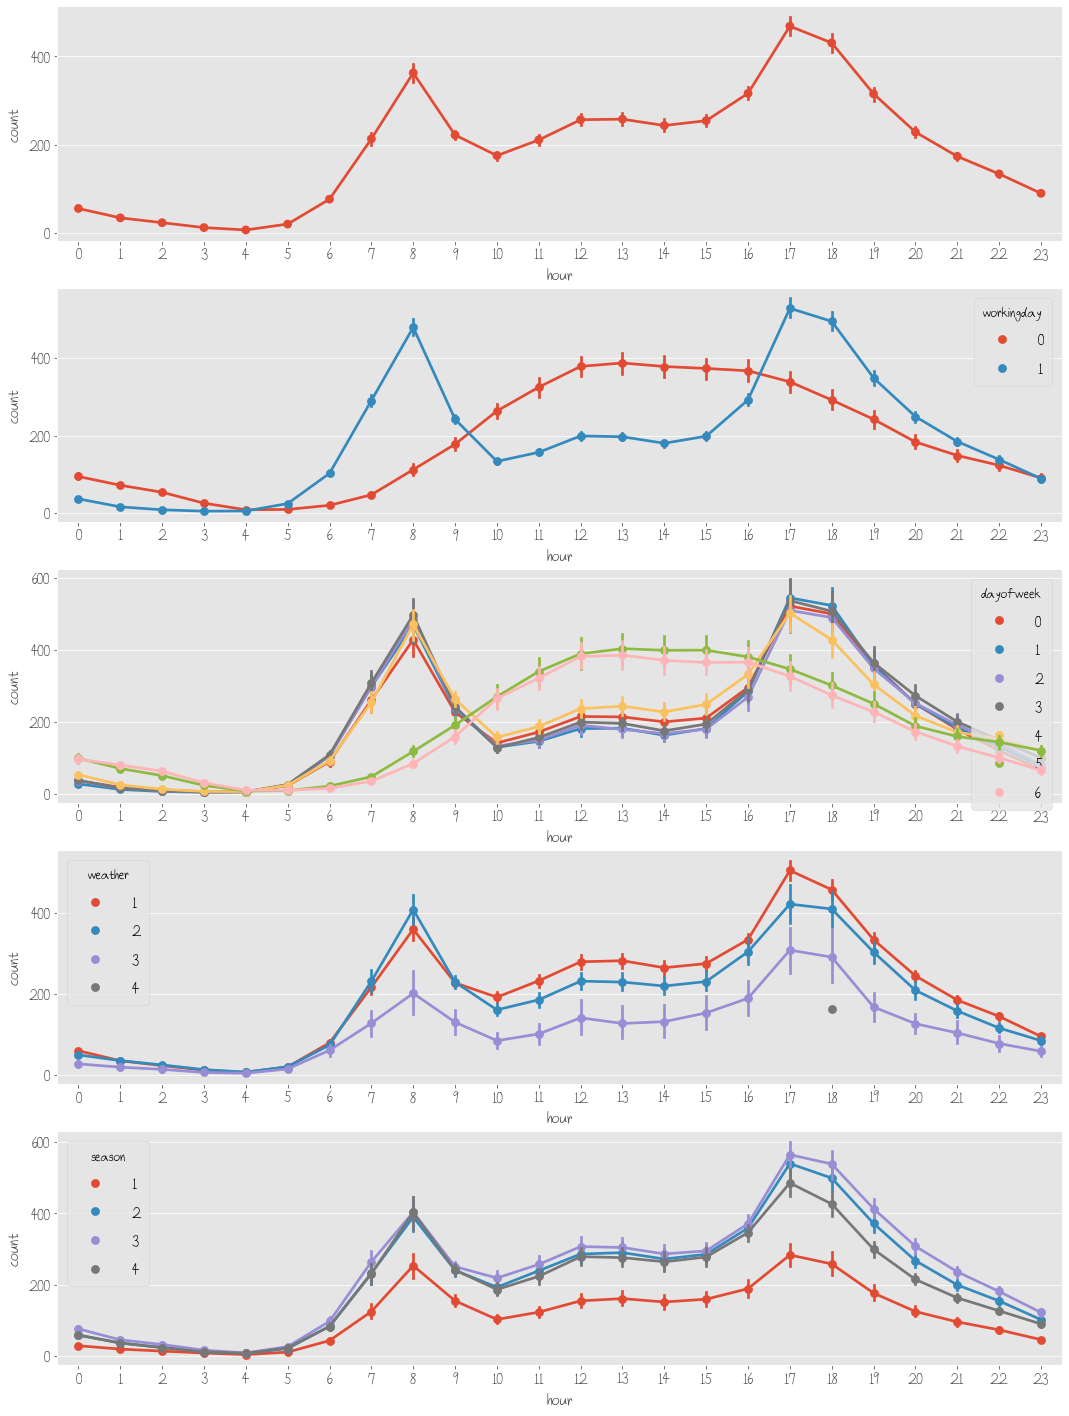

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18, 25)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax5)

In [18]:
# temp, atemp, casual, registered, humidity, windspeed, count 칼럼들의 상관계수를 확인한다
corrmatt = train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']]
corrmatt = corrmatt.corr()

mask = np.array(corrmatt)
mask[np.tril_indices_from(mask)] = False
print(corrmatt)

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

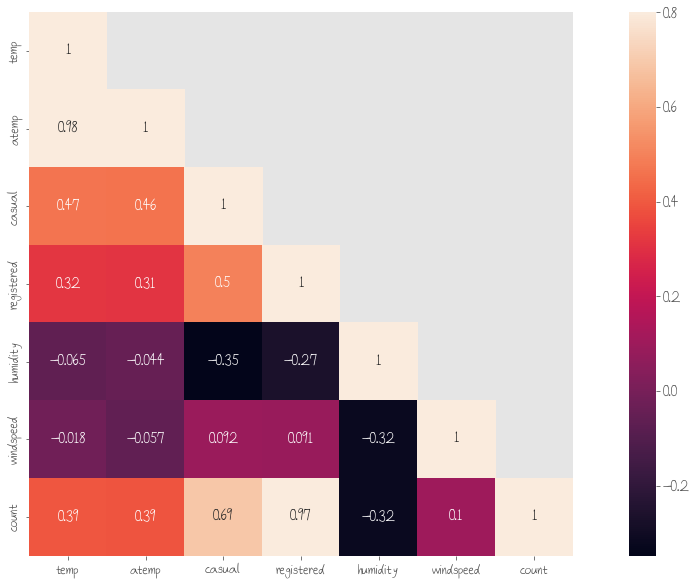

In [19]:
# 상관계수를 히트맵으로 표시
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrmatt, mask=mask, vmax=.8, square=True, annot=True)

- 온도와 습도, 풍속은 상관계수가 적으므로 연관이 없을것 이다
- 대여량과 가장 연관이 높은 것은 registered로 등록 된 대여자가 대여량이 많다
- 온도와 체갑온도의 상관계수는 0.98로 높지만 온도와 체감온도이기 때문에 feature로 사용하기에 적합하지 않을 것이다

<AxesSubplot:xlabel='humidity', ylabel='count'>

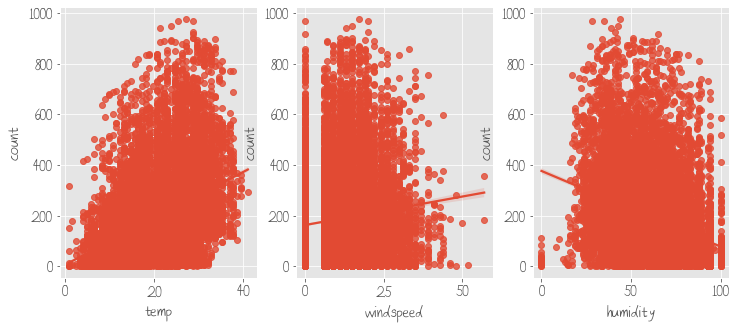

In [20]:
# 온도, 풍속, 습도가 대여량에 미치는 영향을 산점도로 확인한다
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(data=train, x='temp', y='count', ax=ax1)
sns.regplot(data=train, x='windspeed', y='count', ax=ax2)
sns.regplot(data=train, x='humidity', y='count', ax=ax3)

- 풍속은 0일때 대여량이 가장 많이 있지만 이것은 관측되지 않은 값을 0으로 기록한 것으로 추측해서 전처리가 필요하다

In [21]:
# 연도와 월을 연결해서 하나의 칼럼으로 만든다
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek,year_month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5,2011-1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5,2011-1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5,2011-1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5,2011-1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

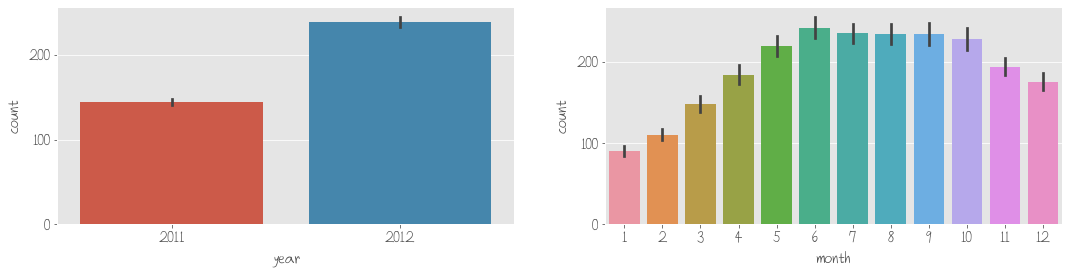

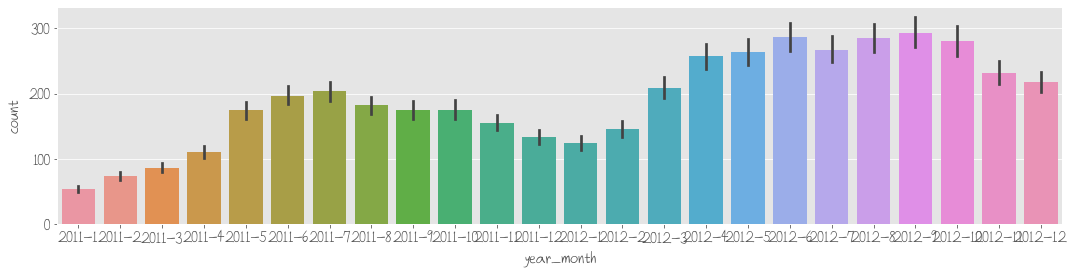

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year_month', y='count', ax=ax3)


- 2011년보다 2012년에 대여량이 더 많다
- 6월에 가장 대여량이 많고 7~10월도 대여량이 많은 편이다
- 겨울보다는 여름에 대여량이 많다
- 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 대여량이 증가하는 추세이다

In [23]:
# 이상치 정제
trainWithoutliers = train[np.abs(train['count'] - train['count'].mean() <= (3*train['count'].std()))]
print(train.shape)
print(trainWithoutliers.shape)

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229774, 4.562423868087808, 0.9581176780909615))

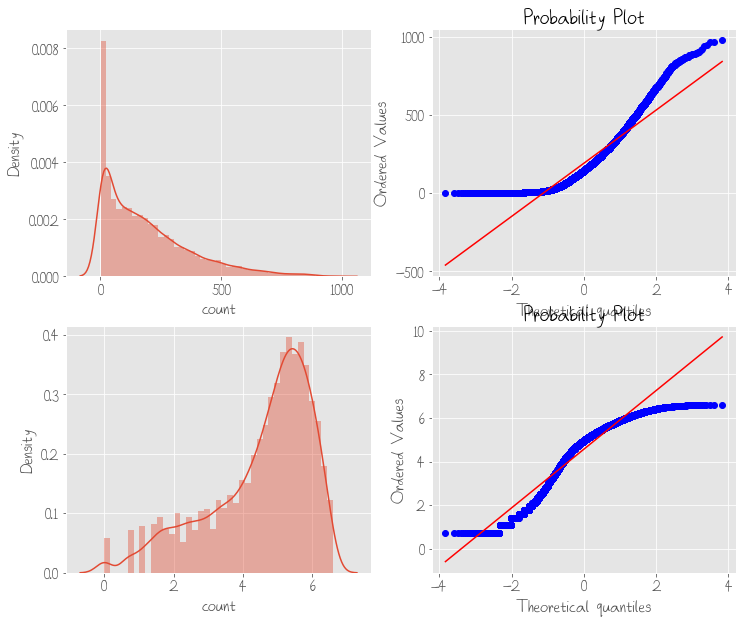

In [24]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.